PART II

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm, truncnorm
import corner
import arviz as az
import seaborn as sns
import pymc as pm
import emcee
from scipy.stats import gaussian_kde
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
from numpyro import infer
numpyro.set_host_device_count(2) # let's use 2 cores!

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

,mg,bp_rp,parallax
0,10.390250,2.731872,10.000008
1,8.608481,2.025819,10.000029
2,4.267759,0.880858,10.000032
3,10.506658,2.649735,10.000066
4,12.077941,2.940875,10.000111
...,...,...,...
227624,11.758283,2.834036,336.026602
227625,9.521769,2.215609,392.752945
227626,14.129570,4.184836,415.179416
227627,11.883816,2.833697,546.975940


In [3]:
# Filtering parallax > 40
nearby_sel = df.parallax > 40
nearby_df = df[nearby_sel]

In [4]:
# Preparing data
x_data = nearby_df['bp_rp'].values 
y_data = nearby_df['mg'].values  

In [5]:
def linear_model_w_outliers(x_data=None, y_data=None, σ_y=None): 
    # Main Sequence (ms) priors
    m_ms = numpyro.sample('m_ms', dist.Uniform(2, 5))  # slope of main sequence
    b_ms = numpyro.sample('b_ms', dist.Uniform(0, 5))  # intercept of main sequence

    μ_ms = m_ms * x_data + b_ms
    dist_ms = dist.Normal(μ_ms, σ_y)  # foreground/inear model/main sequence distribution

    # White Dwarf (wd) priors
    m_wd = numpyro.sample('m_wd', dist.Uniform(2, 5))  # slope of white dwarfs
    b_wd = numpyro.sample('b_wd', dist.Uniform(10, 15))  # intercept of white dwarfs
    
    μ_wd = numpyro.sample('μ_wd', dist.Normal())  # background prior
    σ_wd = numpyro.sample('σ_wd', dist.HalfNormal())  # scatter of white dwarfs
    dist_wd = dist.Normal(μ_wd, jnp.sqrt(σ_wd**2 + σ_y**2)) #background/outliers/White dwarf distribution
     

    # Prior for mixture weights (probabilities of being from MS or WD)
    p_ms = numpyro.sample('p_ms', dist.Uniform(0, 1))  # Probability of being from the MS population
    p_wd = 1 - p_ms  # Probability of being from the WD population

    # Mixture model (Categorical distribution)
    mixing_dist = dist.Categorical(probs=jnp.array([p_ms, p_wd])) 
    mixture = dist.MixtureGeneral(mixing_dist, [dist_ms, dist_wd])

    # Likelihood - observed data `y`
    with numpyro.plate("data", len(x_data)):
        y_ = numpyro.sample("obs", mixture, obs=y_data)  

        # Log probabilities to track membership probabilities of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "log_p_fg", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )

In [6]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)

# Define the kernel
kernel = NUTS(linear_model_w_outliers)

# Initialize and run MCMC
mcmc = MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=1000
)
mcmc.run(rng_key_, x_data, y_data, σ_y=0.1)

# Print the summary of the MCMC results
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      b_ms      2.61      0.01      2.61      2.59      2.63   1621.43      1.00
      b_wd     12.50      1.44     12.50     10.52     14.95   3533.86      1.00
      m_ms      2.97      0.01      2.97      2.96      2.98   1622.70      1.00
      m_wd      3.51      0.88      3.50      2.01      4.72   2893.64      1.00
      p_ms      0.46      0.01      0.46      0.45      0.48   2626.50      1.00
      μ_wd     10.50      0.07     10.50     10.39     10.61   2443.78      1.00
      σ_wd      3.10      0.05      3.10      3.02      3.18   2678.97      1.00

Number of divergences: 0


C:\Users\rabin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'b_ms'}>,
        <Axes: title={'center': 'b_ms'}>],
       [<Axes: title={'center': 'b_wd'}>,
        <Axes: title={'center': 'b_wd'}>],
       [<Axes: title={'center': 'log_p_fg'}>,
        <Axes: title={'center': 'log_p_fg'}>],
       [<Axes: title={'center': 'm_ms'}>,
        <Axes: title={'center': 'm_ms'}>],
       [<Axes: title={'center': 'm_wd'}>,
        <Axes: title={'center': 'm_wd'}>],
       [<Axes: title={'center': 'p_ms'}>,
        <Axes: title={'center': 'p_ms'}>],
       [<Axes: title={'center': 'μ_wd'}>,
        <Axes: title={'center': 'μ_wd'}>],
       [<Axes: title={'center': 'σ_wd'}>,
        <Axes: title={'center': 'σ_wd'}>]], dtype=object)

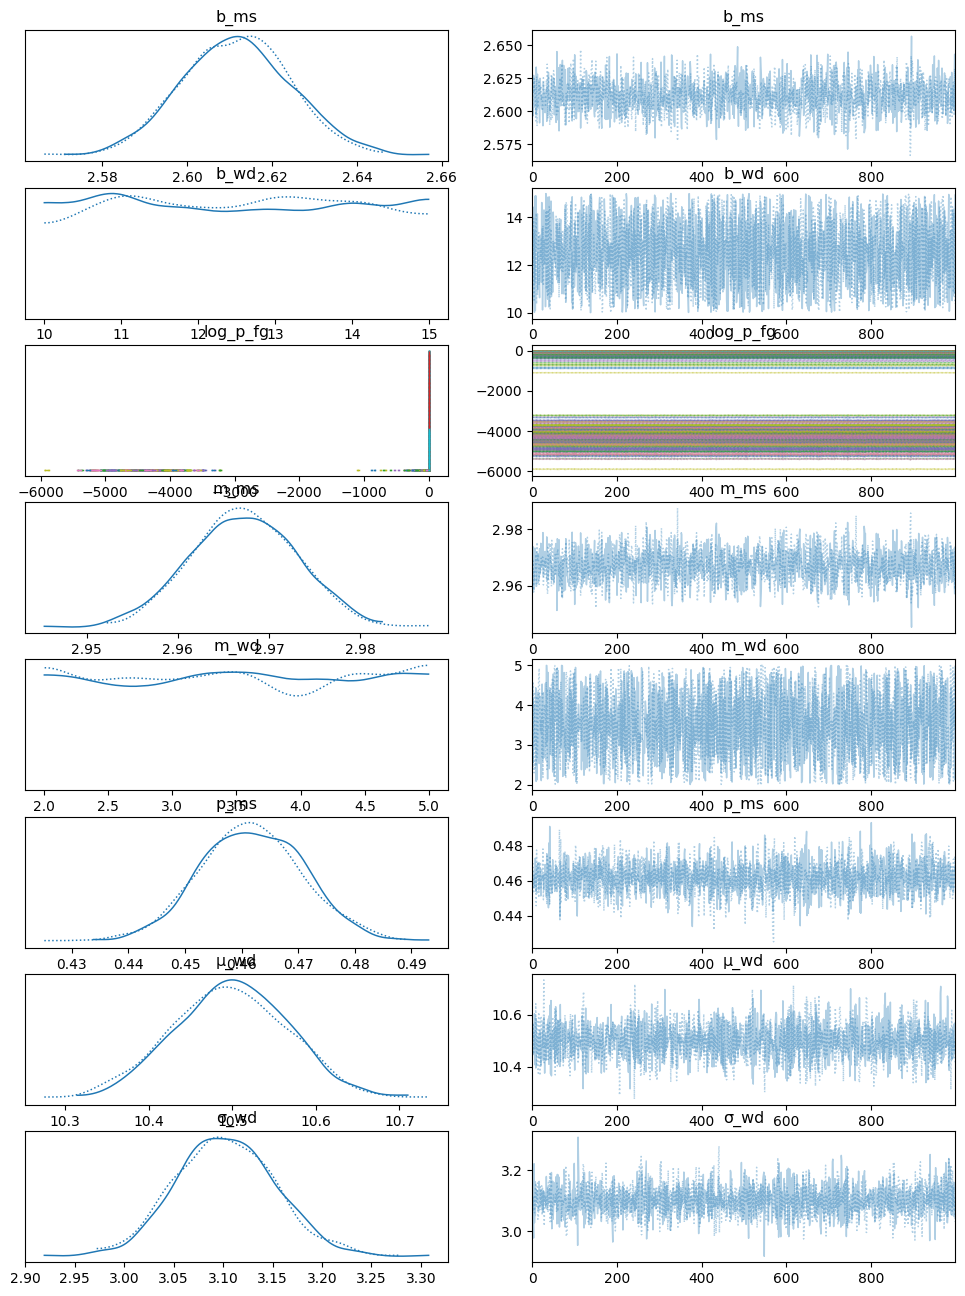

In [7]:
#az.plot_trace(mcmc);
# Convert posterior samples into an ArviZ InferenceData object
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)

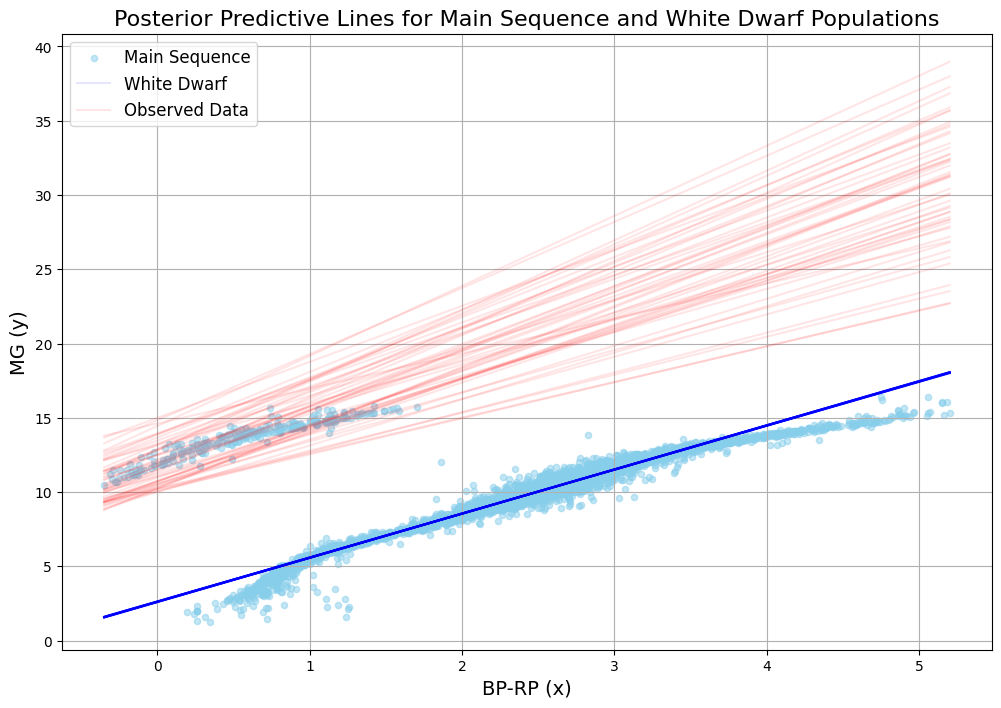

In [ ]:
posterior_samples = mcmc.get_samples()

m_ms_samples = posterior_samples['m_ms']
b_ms_samples = posterior_samples['b_ms']
m_wd_samples = posterior_samples['m_wd']
b_wd_samples = posterior_samples['b_wd'] 

x_vals = np.linspace(min(x_data), max(x_data), 50)

plt.figure(figsize=(12,8))
plt.scatter(x_data, y_data, color='skyblue', alpha=0.5, label='Observed Data', s=20)  

for i in range(50):
    m_ms = m_ms_samples[i]
    b_ms = b_ms_samples[i]
    m_wd = m_wd_samples[i]
    b_wd = b_wd_samples[i]  
   
    plt.plot(x_vals, m_ms * x_vals + b_ms, color='blue', alpha=0.1)  
    plt.plot(x_vals, m_wd * x_vals + b_wd, color='red', alpha=0.1)  

plt.xlabel('BP-RP (x)', fontsize=14)
plt.ylabel('MG (y)', fontsize=14)
plt.title('Posterior Predictive Lines for Main Sequence and White Dwarf Populations', fontsize=16)
plt.legend(['Main Sequence', 'White Dwarf', 'Observed Data'], loc='upper left', fontsize=12)
plt.grid(True)
plt.show()


Q2.Plot the two lines for each of 50 randomly chosen posterior samples from your MCMC. Discuss the quality of the fits, and in particular the constraints. Is the model able to identify the two populations?

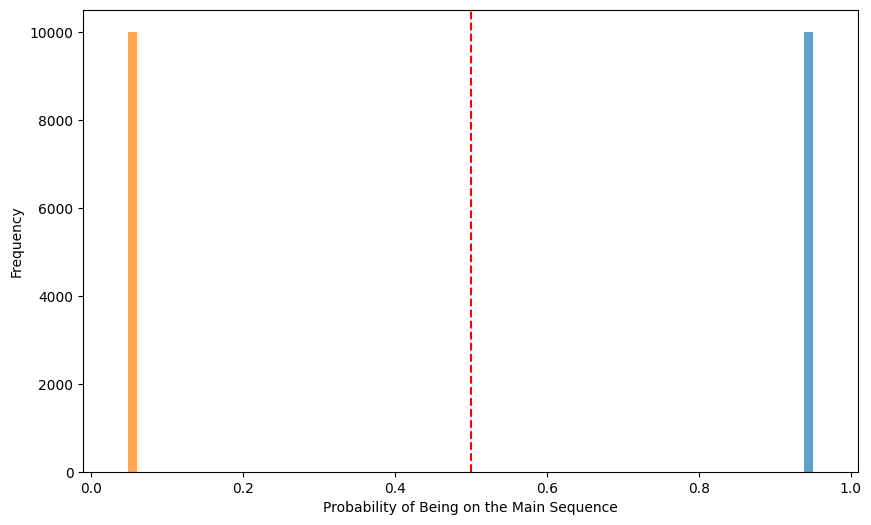

In [ ]:
posterior_samples = mcmc.get_samples()
# Get log probabilities of each component for each star
log_probs = posterior_samples['log_p_fg']  # The log probabilities of each star belonging to MS vs WD
# Convert log probabilities to membership probabilities (softmax)
ms_probabilities = jax.nn.softmax(log_probs)[:, 0]  # Probability of being from the MS population

plt.figure(figsize=(10, 6))
plt.hist(ms_probabilities, bins=30, alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--') # Add a vertical line at the 50% threshold
plt.xlabel('Probability of Being on the Main Sequence')
plt.ylabel('Frequency')
plt.show()


Q3.Graduate students: 

In [8]:
def linear_model_w_outliers_relaxed(x_data=None, y_data=None, σ_y=None): 
    # Main Sequence (ms) priors
    m_ms = numpyro.sample('m_ms', dist.Normal(scale=10))
    b_ms = numpyro.sample('b_ms', dist.Normal(scale=20))

    μ_ms = m_ms * x_data + b_ms
    dist_ms = dist.Normal(μ_ms, σ_y) 

    # White Dwarf (wd) priors
    m_wd = numpyro.sample('m_wd', dist.Normal(scale=10))
    b_wd = numpyro.sample('b_wd', dist.Normal(scale=20))
    
    μ_wd = numpyro.sample('μ_wd', dist.Normal(loc=400, scale=500))  # background prior
    σ_wd = numpyro.sample('σ_wd', dist.HalfNormal(scale=500))  # scatter of white dwarfs

    #Now lets define a model for the background (outliers/White dwarf distribution)(background model + scatter)
    dist_wd = dist.Normal(μ_wd, jnp.sqrt(σ_wd**2 + σ_y**2)) 

    # Prior for mixture weights (probabilities of being from MS or WD)
    p_ms = numpyro.sample('p_ms', dist.Uniform(0, 1))  # Probability of being from the MS population
    p_wd = 1 - p_ms  # Probability of being from the WD population

    # Mixture model (Categorical distribution)
    mixing_dist = dist.Categorical(probs=jnp.array([p_ms, p_wd])) 
    mixture = dist.MixtureGeneral(mixing_dist, [dist_ms, dist_wd])

    # Likelihood - observed data `y`
    with numpyro.plate("data", len(x_data)):
        y_ = numpyro.sample("obs", mixture, obs=y_data)  

        # Log probabilities to track membership probabilities of each sample
        log_probs = mixture.component_log_probs(y_)
        numpyro.deterministic(
            "log_p_fg", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )

In [9]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)

# Define the kernel
kernel = NUTS(linear_model_w_outliers_relaxed)

# Initialize and run MCMC
mcmc = MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=1000
)
mcmc.run(rng_key_, x_data, y_data, σ_y=0.1)

# Print the summary of the MCMC results
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      b_ms      1.72      0.89      1.77      0.78      2.64      1.00     24.95
      b_wd     -0.31     20.17     -0.68    -34.43     30.77   2184.04      1.00
      m_ms      3.81      0.84      3.75      2.95      4.71      1.00     22.10
      m_wd     -0.07     10.22      0.12    -16.95     16.09   2506.05      1.00
      p_ms      0.27      0.19      0.26      0.07      0.47      1.00     31.12
      μ_wd     10.55      0.06     10.55     10.46     10.66   2267.97      1.00
      σ_wd      2.80      0.31      2.77      2.46      3.16      1.01      8.83

Number of divergences: 0


C:\Users\rabin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'b_ms'}>,
        <Axes: title={'center': 'b_ms'}>],
       [<Axes: title={'center': 'b_wd'}>,
        <Axes: title={'center': 'b_wd'}>],
       [<Axes: title={'center': 'log_p_fg'}>,
        <Axes: title={'center': 'log_p_fg'}>],
       [<Axes: title={'center': 'm_ms'}>,
        <Axes: title={'center': 'm_ms'}>],
       [<Axes: title={'center': 'm_wd'}>,
        <Axes: title={'center': 'm_wd'}>],
       [<Axes: title={'center': 'p_ms'}>,
        <Axes: title={'center': 'p_ms'}>],
       [<Axes: title={'center': 'μ_wd'}>,
        <Axes: title={'center': 'μ_wd'}>],
       [<Axes: title={'center': 'σ_wd'}>,
        <Axes: title={'center': 'σ_wd'}>]], dtype=object)

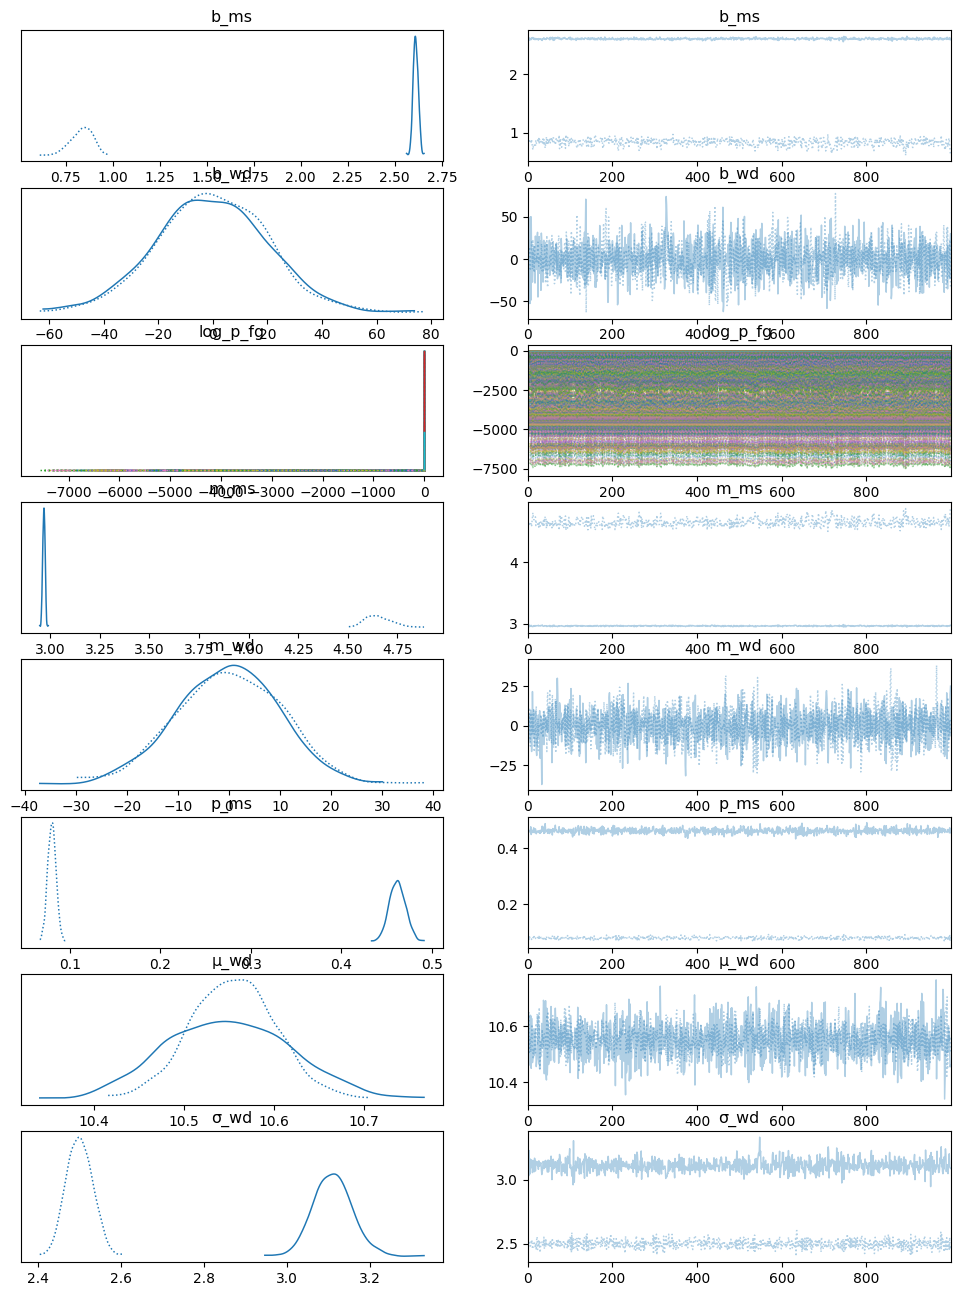

In [10]:
#az.plot_trace(mcmc);
# Convert posterior samples into an ArviZ InferenceData object
idata = az.from_numpyro(mcmc)
az.plot_trace(idata)

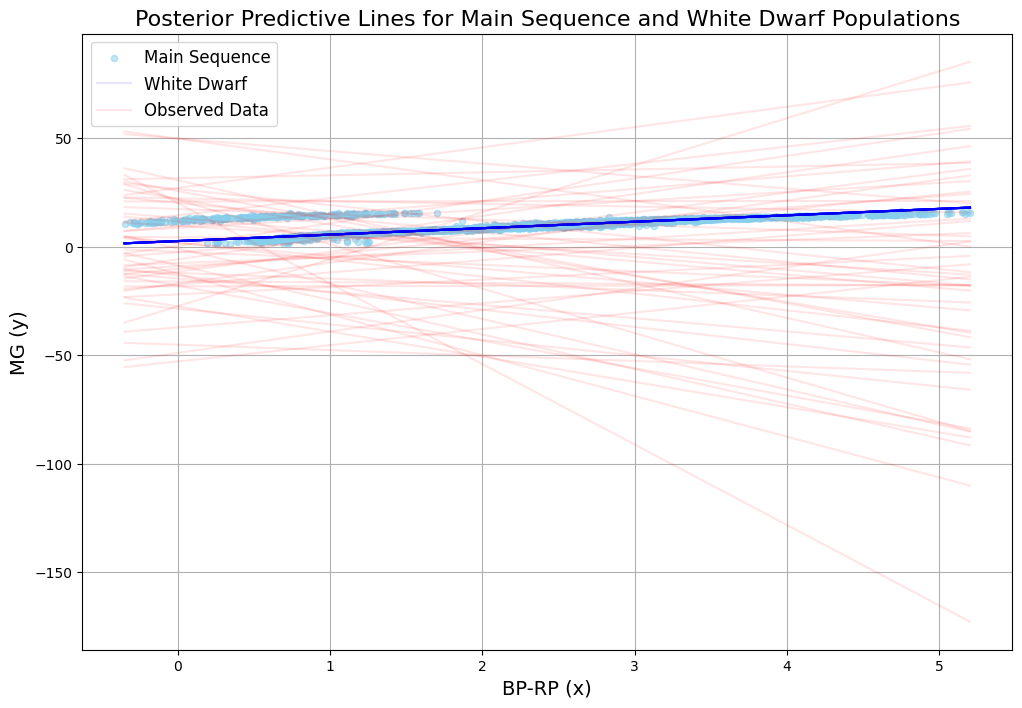

In [ ]:
posterior_samples1 = mcmc.get_samples()

m_ms_samples = posterior_samples1['m_ms']
b_ms_samples = posterior_samples1['b_ms']
m_wd_samples = posterior_samples1['m_wd']
b_wd_samples = posterior_samples1['b_wd'] 

x_vals = np.linspace(min(x_data), max(x_data), 50)

plt.figure(figsize=(12,8))
plt.scatter(x_data, y_data, color='skyblue', alpha=0.5, label='Observed Data', s=20)  

for i in range(50):
    m_ms = m_ms_samples[i]
    b_ms = b_ms_samples[i]
    m_wd = m_wd_samples[i]
    b_wd = b_wd_samples[i]  

    plt.plot(x_vals, m_ms * x_vals + b_ms, color='blue', alpha=0.1)  
    plt.plot(x_vals, m_wd * x_vals + b_wd, color='red', alpha=0.1)  

plt.xlabel('BP-RP')
plt.ylabel('MG')
plt.grid(True)
plt.show()